In [723]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
import matplotlib.cm as cm
from matplotlib.ticker import MaxNLocator
from matplotlib.pyplot import figure, show
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import StandardScaler
import datetime 
import math
import statistics
import seaborn as sns

In [724]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Normalizatin data with means / median

In [725]:
def de_mean_trends(df, standard=False):
  for column in df.columns:
    if column.startswith('symptom:'):
      df[column] = df[column] - df[column].median()
      if standard:
        df[column] = df[column]/df[column].std()

def de_median_trends(df):
  for column in df.columns:
    if column.startswith('symptom:'):
      df[column] = df[column] - df[column].median()


# Function to plot distribution of search frequencies across time

In [726]:
def plot_data(symptoms_df, complete_df, US_symptoms_df):
  
  # iterate through the region
  for index, row in symptoms_df.iterrows():
    region = symptoms_df.open_covid_region_code[index]
    region_df = complete_df.loc[complete_df['open_covid_region_code'] == region]
    region_df = region_df.reset_index(drop = True)
    n_weeks = len(region_df)
    X = np.zeros([4, n_weeks])
    f, ax = plt.subplots(1, 1)

    # iterate through the symptoms
    for i in range(4):
      # the symptom is actually offset by 1 in the column because of the first column, region code
      # check for each symptom out of top 4 symptom searched
      symptom = row.iloc[i + 1]
      # iterate through the weeks
      for j, region_row in region_df.iterrows():
        X[i, j] = region_row[symptom]
      sns.regplot(x = list(range(0, n_weeks)),y = X[i], lowess=True, label=symptom).set_title("Region: " + region)
    ax.legend()
    plt.xlabel("weeks")
    plt.show()
  
  X = np.zeros([4, n_weeks])
  f, ax = plt.subplots(1, 1)

  complete_df.fillna(0)

# __________For the US only_________________________
  # iterate through the symptoms
  us_symptoms = US_symptoms_df.columns[1::]
  i = 0
  for ranking in us_symptoms:
    symptom = US_symptoms_df.iloc[0][ranking]
    # print(symptom)
    symptom_df = complete_df[symptom]
    j = 0
    while j < n_weeks:
      X[i, j] = symptom_df[j]
      j += 1
    sns.regplot(x = list(range(0, n_weeks)),y = X[i], lowess=True, label=symptom).set_title("US")
    i+=1
  ax.legend()
  plt.xlabel("weeks")
  plt.show()



# Clean data (drop all rows / columns with more than 5% of NaN values)

In [727]:
def clean_data(df):
  (rows, cols) = df.shape
  row_threshold = int(rows * 0.2)
  col_threshold = int(cols * 0.2)

# remove row if too many columns are nan and vice versa
  df = df.dropna(axis = 0, thresh = col_threshold)
  df = df.dropna(axis = 1, thresh = row_threshold)
  df = df.reset_index(drop = True)
  (rows, cols) = df.shape
  return df


# K-Means

In [728]:
def classify_KMeans(complete_df):
  complete_df = complete_df.reset_index(drop = True)
  complete_df = complete_df.fillna(0)
  X = complete_df[complete_df.columns[pd.Series(complete_df.columns).str.startswith('symptom')]]
  (rows, columns) = X.shape
  range_n_clusters = list(range(5, 50))

  best_average = 0
  best_K = 0

  for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    if silhouette_avg > best_average:
      best_average = silhouette_avg
      best_k = n_clusters
  
  # using K-Means with best K
  print("best number of clusters is: ", best_k)
  kmeans = KMeans(n_clusters=best_k)
  kmeans.fit(X)
  y_kmeans = kmeans.predict(X)
  X = PCA(n_components=2, random_state = 1).fit_transform(X)
  plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50)
  plt.title("K-Means using PCA")
  plt.show()


  # using K-Means with best K
  print("best number of clusters is: ", best_k)
  kmeans = KMeans(n_clusters=best_k)
  kmeans.fit(X)
  y_kmeans = kmeans.predict(X)
  X = TSNE(n_components=2, random_state = 1).fit_transform(X)
  plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50)
  plt.title("K-Means using tSNE")
  plt.show()

  # checking directly with tSNE for all regions (comparable to PCA)
  regions = complete_df.open_covid_region_code.unique()
  labelled_regions = complete_df.open_covid_region_code

  # generate colors for all possible states

  generate_rand = lambda n: list(map(lambda i: "#" + "%06x" % random.randint(0, 0xFFFFFF),range(n)))
  colors = generate_rand(60)
  print(colors)
  # colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', '#17becf', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
  c_map = []
  for i in range(rows):
    region = complete_df['open_covid_region_code'][i]
    index = np.where(regions == region)[0][0]
    c_map.append(colors[index])

  plt.scatter(X[:, 0], X[:, 1], c=c_map, s=50)
  plt.title("t-SNE clustered by region")
  plt.show()

# *PCA* Standardization and reduction function




In [729]:
def PCAtransformation(df):
    ndf = np.nan_to_num(df) # if col = NAN, col = 0
    x_pca = pca2.fit_transform(ndf) #transform data
    #compresses 120 features into two PCA components
    x_pca = pd.DataFrame(data = x_pca, columns = ['principal component 1', 'principal component 2'])
    print(x_pca)
    return x_pca

# Decision Tree Regressor

In [730]:
def decisionTree_regressor_test(complete_df, split_type):
    
  complete_df = complete_df.reset_index(drop = True)
  complete_df = complete_df.fillna(0)

  if split_type == 'region':
    splitted = complete_df.open_covid_region_code.unique()
    column = 'open_covid_region_code'
  else:
    splitted = complete_df.date.unique()
    column = 'date'

  splitted = np.array_split(np.array(splitted),5)
  print(splitted)
  for test_list in splitted:

    # there are 5 cv for 20-80 split
    train = complete_df[~complete_df[column].isin(test_list)]
    test = complete_df[complete_df[column].isin(test_list)]

    X_train = train[train.columns[pd.Series(train.columns).str.startswith('symptom')]]
    # X_train = preprocessing.StandardScaler().fit(X_train).transform(X_train.astype(float))

    print(test[column].unique())
    X_test = test[test.columns[pd.Series(test.columns).str.startswith('symptom')]]
    # X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test.astype(float))

    Y_train = train['hospitalized_new']

    Y_test = test['hospitalized_new']

    error_rate = []
    for i in range(1,101):
      dt = DecisionTreeRegressor(min_samples_leaf = i)
      dt.fit(X_train,Y_train)
      pred_i = dt.predict(X_test)
      error_rate.append(np.mean((pred_i - Y_test)**2))

    plt.figure(figsize=(10,6))
    plt.plot(range(1,101),error_rate,color='blue', linestyle='dashed', 
            marker='o',markerfacecolor='red', markersize=10)
    if split_type == 'region':
      plt.title("By Date: Validation on " + (','.join(test_list)))
    else:
      start = pd.to_datetime(test_list[0])
      end = pd.to_datetime(test_list[-1])
      plt.title('By Date ' + str(start.date()) +  ' to ' + str(end.date()))    
    plt.xlabel('Depth')
    plt.ylabel('Error Rate')
    print("Minimum error: ",min(error_rate),"at depth level =",error_rate.index(min(error_rate))+1)

In [731]:
def decisionTree_classifier_correct(complete_df, split_type):
  
  complete_df = complete_df.reset_index(drop = True)
  complete_df = complete_df.fillna(0)

  if split_type == 'region':
    X = complete_df[complete_df.columns[pd.Series(complete_df.columns).str.startswith('symptom')]]
    y = complete_df[['hospitalized_new']]
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    error_rate = []
    std_rate = []

    for i in range(1,101):
      dt = DecisionTreeRegressor(min_samples_leaf=i)
      cv_scores = cross_val_score(dt, X, y, cv=5, scoring='neg_mean_squared_error')
      error_rate.append(abs(cv_scores.mean()))
      std_rate.append(abs(cv_scores.std()));

    print("Minimum error: ",min(error_rate),"at depth =",error_rate.index(min(error_rate)) + 1)

    plt.figure(figsize=(10,6))
    plt.plot(range(1,101),error_rate,color='blue', linestyle='dashed', 
            marker='o',markerfacecolor='red', markersize=10)
    plt.title("Decision tree by region MSE")
    plt.xlabel('K')
    plt.ylabel('MSE')
    plt.show()


    plt.figure(figsize=(10,6))
    plt.plot(range(1,101),std_rate,color='blue', linestyle='dashed', 
            marker='o',markerfacecolor='red', markersize=10)
    plt.title("Decision tree by region Standard deviation")
    plt.xlabel('K')
    plt.ylabel('Standard deviation')
    plt.show()

    dt = DecisionTreeRegressor(max_features = "sqrt")
    cv_scores = cross_val_score(dt, X, y, cv=5, scoring='neg_mean_squared_error')
    print("Best Score from sqrt: ", (abs(cv_scores.mean())));
    accuracy = cross_val_score(dt, X, y, cv=5, scoring='accuracy')
    print("Accuracy: ", accuracy)

  else:
    d_day = datetime.datetime(2020, 8, 10) 
    # one split
    train = complete_df[complete_df['date'] < (d_day)]
    test = complete_df[complete_df['date'] >= (d_day)]

    X_train = train[train.columns[pd.Series(train.columns).str.startswith('symptom')]]
    # X_train = preprocessing.StandardScaler().fit(X_train).transform(X_train.astype(float))

    X_test = test[test.columns[pd.Series(test.columns).str.startswith('symptom')]]
    # X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test.astype(float))

    Y_train = train['hospitalized_new']

    Y_test = test['hospitalized_new']

    error_rate = []
    for i in range(1,50):
      dt = DecisionTreeRegressor(min_samples_leaf = i)
      dt.fit(X_train,Y_train)
      pred_i = dt.predict(X_test)
      error_rate.append(mean_squared_error(Y_test, pred_i))

    plt.figure(figsize=(10,6))
    plt.plot(range(1,50),error_rate,color='blue', linestyle='dashed', 
            marker='o',markerfacecolor='red', markersize=10)
    plt.title('Decision tree MSE by date ')
    plt.xlabel('K')
    plt.ylabel('Error Rate')
    print("Minimum error: ",min(error_rate),"at K =",error_rate.index(min(error_rate))+1)

    dt = DecisionTreeRegressor(max_features = "sqrt")
    dt.fit(X_train,Y_train)
    pred_i = dt.predict(X_test)
    print("Best Score: ", (mean_squared_error(Y_test, pred_i)))
    print("Accuracy: ", accuracy_score(Y_test, pred_i))


# KNN Regressor

In [732]:
def knn_classifier_test(complete_df, split_type):
  
  complete_df = complete_df.reset_index(drop = True)
  complete_df = complete_df.fillna(0)

  if split_type == 'region':
    splitted = complete_df.open_covid_region_code.unique()
    column = 'open_covid_region_code'
  else:
    splitted = complete_df.date.unique()
    column = 'date'

  splitted = np.array_split(np.array(splitted),5)
  print(splitted)
  for test_list in splitted:

    # there are 5 cv for 20-80 split
    train = complete_df[~complete_df[column].isin(test_list)]
    test = complete_df[complete_df[column].isin(test_list)]

    X_train = train[train.columns[pd.Series(train.columns).str.startswith('symptom')]]
    # X_train = preprocessing.StandardScaler().fit(X_train).transform(X_train.astype(float))

    print(test[column].unique())
    X_test = test[test.columns[pd.Series(test.columns).str.startswith('symptom')]]
    # X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test.astype(float))

    Y_train = train['hospitalized_new']

    Y_test = test['hospitalized_new']


    # k = 10
    # neighbhoor = KNeighborsClassifier(n_neighbors = k).fit(X_train,Y_train)
    # Pred_y = neighbhoor.predict(X_test)
    # print("Accuracy of model at K=4 is",metrics.accuracy_score(Y_test, Pred_y))
    error_rate = []
    for i in range(1,101):
      knn = KNeighborsRegressor(n_neighbors=i)
      knn.fit(X_train,Y_train)
      pred_i = knn.predict(X_test)
      error_rate.append(np.mean((pred_i - Y_test)**2))

    plt.figure(figsize=(10,6))
    plt.plot(range(1,101),error_rate,color='blue', linestyle='dashed', 
            marker='o',markerfacecolor='red', markersize=10)
    if split_type == 'region':
      plt.title("By Date: Validation on " + (','.join(test_list)))
    else:
      start = pd.to_datetime(test_list[0])
      end = pd.to_datetime(test_list[-1])
      plt.title('By Date ' + str(start.date()) +  ' to ' + str(end.date()))
    plt.xlabel('K')
    plt.ylabel('MSE')
    print("Minimum error: ",min(error_rate),"at K =",error_rate.index(min(error_rate))+1)


In [733]:
def knn_classifier_correct(complete_df, split_type):
  
  complete_df = complete_df.reset_index(drop = True)
  complete_df = complete_df.fillna(0)

  if split_type == 'region':
    X = complete_df[complete_df.columns[pd.Series(complete_df.columns).str.startswith('symptom')]]
    y = complete_df[['hospitalized_new']]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    error_rate = []
    std_rate = []
    for i in range(1,101):
      knn = KNeighborsRegressor(n_neighbors=i)
      cv_scores = cross_val_score(knn, X, y, cv=5, scoring='neg_mean_squared_error')
      error_rate.append(abs(cv_scores.mean()))
      std_rate.append(abs(cv_scores.std()));

    plt.figure(figsize=(10,6))
    plt.plot(range(1,101),error_rate,color='blue', linestyle='dashed', 
            marker='o',markerfacecolor='red', markersize=10)
    plt.title("KNN by region MSE")
    plt.xlabel('K')
    plt.ylabel('MSE')
    print("Minimum error: ",min(error_rate), "with std: ", std_rate[error_rate.index(min(error_rate))] ," at K =",error_rate.index(min(error_rate)) +1)


    plt.figure(figsize=(10,6))
    plt.plot(range(1,101),std_rate,color='blue', linestyle='dashed', 
            marker='o',markerfacecolor='red', markersize=10)
    plt.title("KNN by region Standard deviation")
    plt.xlabel('K')
    plt.ylabel('Standard deviation')
    plt.show()

# _____________________________________________best k _______________________________
    k_pick = int(math.sqrt(complete_df.shape[0]))
    if k_pick % 2 == 0:
      k_pick += 1
    knn = KNeighborsRegressor(n_neighbors=k_pick)
    cv_scores = cross_val_score(knn, X, y, cv=5, scoring='neg_mean_squared_error')
    k_squaredN = (abs(cv_scores.mean()))

    print("Accord to k = sqrt(n) ",k_pick, " error is: ", k_squaredN)

  else:
    d_day = datetime.datetime(2020, 8, 10) 
    # one split
    preprocess_df = complete_df
    # preprocess_df[preprocess_df.columns[pd.Series(preprocess_df.columns).str.startswith('symptom')]] = preprocessing.StandardScaler().fit(preprocess_df[preprocess_df.columns[pd.Series(preprocess_df.columns).str.startswith('symptom')]]).transform(preprocess_df[preprocess_df.columns[pd.Series(preprocess_df.columns).str.startswith('symptom')]].astype(float))

    train = preprocess_df[preprocess_df['date'] < (d_day)]
    test = preprocess_df[preprocess_df['date'] >= (d_day)]

    X_train = train[train.columns[pd.Series(train.columns).str.startswith('symptom')]]
    # X_train = preprocessing.StandardScaler().fit(X_train).transform(X_train.astype(float))

    X_test = test[test.columns[pd.Series(test.columns).str.startswith('symptom')]]
    # X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test.astype(float))

    Y_train = train['hospitalized_new']

    Y_test = test['hospitalized_new']

    # k = 10
    # neighbhoor = KNeighborsClassifier(n_neighbors = k).fit(X_train,Y_train)
    # Pred_y = neighbhoor.predict(X_test)
    # print("Accuracy of model at K=4 is",metrics.accuracy_score(Y_test, Pred_y))
    error_rate = []
    for i in range(1,50):
      knn = KNeighborsRegressor(n_neighbors=i)
      knn.fit(X_train,Y_train)
      pred_i = knn.predict(X_test)
      error_rate.append(mean_squared_error(Y_test, pred_i))

    plt.figure(figsize=(10,6))
    plt.plot(range(1,50),error_rate,color='blue', linestyle='dashed', 
            marker='o',markerfacecolor='red', markersize=10)
    plt.title('KNN MSE by date ')
    plt.xlabel('K')
    plt.ylabel('MSE')
    print("Minimum error: ",min(error_rate),"at K =",error_rate.index(min(error_rate))+1)


    # _______________________________________Square root for MSE ____________________

    k_pick = int(math.sqrt(preprocess_df.shape[0]))
    if k_pick % 2 == 0:
      k_pick += 1
    knn = KNeighborsRegressor(n_neighbors=k_pick)
    knn.fit(X_train,Y_train)
    pred_i = knn.predict(X_test)
    k_squaredN = mean_squared_error(Y_test, pred_i)

    print("Accord to k = sqrt(n) ",k_pick, " error is: ", k_squaredN)


# Main

In [734]:
cases_df = pd.read_csv("drive/My Drive/COMP551/assignment1/aggregated_cc_by.csv")
trends_df = pd.read_csv("drive/My Drive/COMP551/assignment1//2020_US_weekly_symptoms_dataset.csv")
trends_df.head()
# # _____________________________________________Experimentation with daily dataset (might not work, keeping all symptoms)________________
# daily_trends_df = pd.read_csv("drive/My Drive/COMP551/assignment1//2020_US_daily_symptoms_dataset.csv")
# daily_trends_df['date']=daily_trends_df['date'].astype('datetime64[ns]')
# daily_to_weekly_trends_df = daily_trends_df.groupby(['open_covid_region_code']).resample('W', on= "date").sum()
# daily_to_weekly_trends_df['country_region_code'] = 'US'
# trends_df = daily_to_weekly_trends_df
# trends_df = trends_df.reset_index()
# trends_df.head()

# _____________________________________________Experimentation with daily dataset (might notwork, only keeping symptoms of COVID19)________________
# daily_trends_df = pd.read_csv("drive/My Drive/COMP551/assignment1//2020_US_daily_symptoms_dataset.csv")
# daily_trends_df['date']=daily_trends_df['date'].astype('datetime64[ns]')
# daily_to_weekly_trends_df = daily_trends_df.groupby(['open_covid_region_code']).resample('W', on= "date").sum()
# daily_to_weekly_trends_df['country_region_code'] = 'US'
# trends_df = daily_to_weekly_trends_df
# trends_df = trends_df.reset_index()
# trends_df = trends_df[['open_covid_region_code', 'date', 'symptom:Fever', 'symptom:Cough', 'symptom:Fatigue', 'symptom:Sore throat', 'symptom:Headache', 'symptom:Conjunctivitis', 'symptom:Shortness of breath', 'symptom:Chest pain', 'symptom:Skin rash']]
# print(trends_df)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,open_covid_region_code,country_region_code,country_region,sub_region_1,sub_region_1_code,sub_region_2,sub_region_2_code,date,symptom:Abdominal obesity,symptom:Abdominal pain,symptom:Acne,symptom:Actinic keratosis,symptom:Acute bronchitis,symptom:Adrenal crisis,symptom:Ageusia,symptom:Alcoholism,symptom:Allergic conjunctivitis,symptom:Allergy,symptom:Amblyopia,symptom:Amenorrhea,symptom:Amnesia,symptom:Anal fissure,symptom:Anaphylaxis,symptom:Anemia,symptom:Angina pectoris,symptom:Angioedema,symptom:Angular cheilitis,symptom:Anosmia,symptom:Anxiety,symptom:Aphasia,symptom:Aphonia,symptom:Apnea,symptom:Arthralgia,symptom:Arthritis,symptom:Ascites,symptom:Asperger syndrome,symptom:Asphyxia,symptom:Asthma,symptom:Astigmatism,symptom:Ataxia,...,symptom:Throat irritation,symptom:Thrombocytopenia,symptom:Thyroid nodule,symptom:Tic,symptom:Tinnitus,symptom:Tonsillitis,symptom:Toothache,symptom:Tremor,symptom:Trichoptilosis,symptom:Tumor,symptom:Type 2 diabetes,symptom:Unconsciousness,symptom:Underweight,symptom:Upper respiratory tract infection,symptom:Urethritis,symptom:Urinary incontinence,symptom:Urinary tract infection,symptom:Urinary urgency,symptom:Uterine contraction,symptom:Vaginal bleeding,symptom:Vaginal discharge,symptom:Vaginitis,symptom:Varicose veins,symptom:Vasculitis,symptom:Ventricular fibrillation,symptom:Ventricular tachycardia,symptom:Vertigo,symptom:Viral pneumonia,symptom:Visual acuity,symptom:Vomiting,symptom:Wart,symptom:Water retention,symptom:Weakness,symptom:Weight gain,symptom:Wheeze,symptom:Xeroderma,symptom:Xerostomia,symptom:Yawn,symptom:hyperhidrosis,symptom:pancreatitis
0,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-01-06,NaN,NaN,NaN,NaN,NaN,12.69,NaN,NaN,NaN,NaN,NaN,12.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.31,NaN,NaN,NaN,...,NaN,NaN,15.86,NaN,NaN,NaN,NaN,NaN,11.90,NaN,NaN,NaN,NaN,18.84,13.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.08,9.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.28,NaN,NaN
1,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-01-13,NaN,NaN,NaN,NaN,NaN,9.56,NaN,NaN,NaN,NaN,NaN,12.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.20,NaN,NaN,NaN,...,NaN,NaN,12.24,NaN,NaN,NaN,NaN,NaN,7.84,NaN,NaN,NaN,NaN,16.83,13.01,NaN,NaN,7.65,NaN,NaN,NaN,NaN,NaN,15.30,8.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.26,NaN,NaN
2,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-01-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.90,NaN,NaN,NaN,...,NaN,NaN,17.66,NaN,NaN,NaN,NaN,NaN,15.27,NaN,NaN,NaN,NaN,18.40,12.14,NaN,NaN,7.54,NaN,NaN,NaN,NaN,NaN,10.30,16.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.48,NaN,NaN
3,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-01-27,NaN,NaN,NaN,NaN,NaN,15.31,7.47,NaN,NaN,NaN,NaN,15.67,NaN,NaN,NaN,NaN,NaN,NaN,7.47,NaN,NaN,NaN,7.65,NaN,NaN,NaN,NaN,NaN,12.03,NaN,NaN,NaN,...,NaN,NaN,12.76,NaN,NaN,NaN,NaN,NaN,9.84,NaN,NaN,NaN,NaN,20.41,17.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.93,NaN,NaN
4,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-02-03,NaN,NaN,NaN,NaN,NaN,8.81,NaN,NaN,NaN,NaN,NaN,13.87,NaN,NaN,NaN,NaN,NaN,NaN,8.06,NaN,NaN,NaN,12.56,NaN,NaN,NaN,NaN,NaN,14.24,NaN,NaN,NaN,...,NaN,NaN,16.68,NaN,NaN,NaN,NaN,NaN,10.68,NaN,NaN,NaN,NaN,20.62,16.87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.24,10.68,NaN,NaN,10.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.93,NaN,NaN


In [735]:
us_states = trends_df.open_covid_region_code.unique()
us_cases = cases_df[cases_df['open_covid_region_code'].isin(us_states)]
us_cases = us_cases.reset_index(drop = True)
us_cases = us_cases[['open_covid_region_code', 'region_name', 'date', 'hospitalized_new']]
# print(us_cases)

# us_cases.open_covid_region_code.unique()

In [736]:
us_cases = us_cases[['open_covid_region_code', 'date', 'hospitalized_new']]
us_cases.head()
print(us_cases)

     open_covid_region_code       date  hospitalized_new
0                     US-WY   3/7/2020               0.0
1                     US-WY   3/8/2020               0.0
2                     US-WY   3/9/2020               0.0
3                     US-WY  3/10/2020               0.0
4                     US-WY  3/11/2020               0.0
...                     ...        ...               ...
3357                  US-AK  9/27/2020               0.0
3358                  US-AK  9/28/2020               0.0
3359                  US-AK  9/29/2020               0.0
3360                  US-AK  9/30/2020               0.0
3361                  US-AK  10/1/2020               0.0

[3362 rows x 3 columns]


In [737]:
print("Before cleaning:")
print(trends_df.shape)

trends_df = clean_data(trends_df)

print("After cleaning:")
print(trends_df.shape)
# de_median_trends(trends_df)



import statistics
import math

def normalize(df):
  frames = []
  for state in df["open_covid_region_code"].unique():
    medians = []
    for column in df[df['open_covid_region_code'] == state].columns:
      if column.startswith('symptom:'):
        medians.append(df[df['open_covid_region_code'] == state][column].median())

    medians = [x for x in medians if not math.isnan(x)]
    region_median = statistics.median(medians)

    print(state, region_median)

    symptoms = [name for name in trends_df.columns if name.startswith('symptom:')]
    symptoms_df = trends_df[symptoms][trends_df['open_covid_region_code'] == state] / region_median

    ids = [name for name in trends_df.columns if not name.startswith('symptom:')]
    ids_df = trends_df[ids][trends_df['open_covid_region_code'] == state]
    
    frames.append(ids_df.join(symptoms_df))

  return pd.concat(frames)

trends_df = normalize(trends_df)
trends_df.head()

Before cleaning:
(608, 430)
After cleaning:
(200, 100)
US-AK 10.055
US-MT 12.74
US-ND 8.8875
US-SD 10.69
US-VT 11.76
US-WY 3.5375


,open_covid_region_code,country_region_code,country_region,sub_region_1,sub_region_1_code,date,symptom:Adrenal crisis,symptom:Ageusia,symptom:Amenorrhea,symptom:Anosmia,symptom:Asphyxia,symptom:Atheroma,symptom:Auditory hallucination,symptom:Balance disorder,symptom:Beau's lines,symptom:Bleeding on probing,symptom:Burning mouth syndrome,symptom:Cataplexy,symptom:Chorea,symptom:Cleft lip and cleft palate,symptom:Clouding of consciousness,symptom:Crackles,symptom:Crepitus,symptom:Croup,symptom:Cyanosis,symptom:Depersonalization,symptom:Developmental disability,symptom:Dysautonomia,symptom:Dysgeusia,symptom:Dyspareunia,symptom:Dystonia,symptom:Dysuria,symptom:Epiphora,symptom:Esophagitis,symptom:Eye pain,symptom:Facial swelling,symptom:Fibrocystic breast changes,symptom:Focal seizure,symptom:Gastroparesis,symptom:Gingival recession,...,symptom:Malabsorption,symptom:Male infertility,symptom:Mitral insufficiency,symptom:Muscle atrophy,symptom:Myoclonus,symptom:Nasal polyp,symptom:Neck mass,symptom:Neutropenia,symptom:Night terror,symptom:Nocturnal enuresis,symptom:Nystagmus,symptom:Onychorrhexis,symptom:Osteophyte,symptom:Papule,symptom:Pericarditis,symptom:Petechia,symptom:Photophobia,symptom:Polyuria,symptom:Ptosis,symptom:Pulmonary edema,symptom:Rectal pain,symptom:Rectal prolapse,symptom:Rheum,symptom:Round ligament pain,symptom:Rumination,symptom:Sensitivity to sound,symptom:Spasticity,symptom:Splenomegaly,symptom:Sputum,symptom:Stomach rumble,symptom:Stridor,symptom:Subdural hematoma,symptom:Tachypnea,symptom:Tenderness,symptom:Thyroid nodule,symptom:Trichoptilosis,symptom:Upper respiratory tract infection,symptom:Urethritis,symptom:Urinary urgency,symptom:Ventricular fibrillation
0,US-AK,US,United States,Alaska,US-AK,2020-01-06,1.262059,NaN,1.222277,NaN,1.025361,1.103928,0.887121,1.103928,0.788662,1.183491,1.203381,1.222277,1.203381,1.795127,NaN,0.828444,1.242168,2.563899,1.045251,1.203381,1.597215,NaN,0.788662,0.788662,1.478866,1.538538,0.808553,0.907011,1.538538,0.867230,1.755346,0.946793,1.143710,1.143710,...,1.538538,1.795127,1.143710,NaN,1.045251,0.946793,1.183491,NaN,1.340627,1.222277,1.281949,0.966683,1.656887,1.123819,0.808553,1.103928,1.143710,0.907011,1.123819,1.123819,NaN,1.814023,NaN,1.420189,1.360517,0.808553,0.907011,0.828444,1.814023,NaN,1.025361,0.985579,0.788662,1.420189,1.577325,1.183491,1.873695,1.380408,NaN,0.985579
1,US-AK,US,United States,Alaska,US-AK,2020-01-13,0.950771,NaN,1.255097,NaN,1.312780,1.312780,0.856290,1.084038,1.179513,0.950771,1.027350,1.483839,1.140726,3.461959,0.989557,0.817504,NaN,2.491298,1.179513,0.760816,2.015912,1.102934,NaN,NaN,1.769269,1.293884,1.273993,1.065142,1.160617,1.160617,1.065142,1.160617,1.654898,1.312780,...,NaN,1.102934,0.817504,1.388364,0.836400,0.760816,1.140726,NaN,1.331676,1.312780,0.779712,1.388364,1.369468,1.312780,1.140726,1.102934,0.817504,0.969667,0.779712,0.798608,0.836400,2.034809,1.140726,1.825957,NaN,0.875186,0.950771,1.084038,1.769269,0.912979,1.540527,1.369468,1.065142,1.331676,1.217305,0.779712,1.673794,1.293884,0.760816,0.836400
2,US-AK,US,United States,Alaska,US-AK,2020-01-20,NaN,NaN,1.409249,0.731974,1.481850,1.043262,0.823471,1.171556,1.189458,1.756340,1.115863,1.097961,1.152660,1.903531,0.878170,0.823471,1.043262,2.982596,0.768772,NaN,2.397812,1.006464,1.097961,0.841372,1.775236,1.573347,0.969667,0.914968,1.518647,1.080060,1.446047,1.629040,1.317752,0.897066,...,1.189458,0.878170,1.097961,1.043262,0.768772,1.738439,1.189458,1.061164,0.897066,1.024366,1.317752,1.354550,1.409249,1.390353,0.823471,1.043262,1.080060,0.805569,1.080060,0.860269,0.786673,1.829935,0.914968,1.537544,1.390353,0.841372,0.951765,1.226256,2.488314,0.841372,1.481850,0.914968,1.226256,1.280955,1.756340,1.518647,1.829935,1.207360,0.749876,1.610144
3,US-AK,US,United States,Alaska,US-AK,2020-01-27,1.522626,0.742914,1.558429,NaN,1.196420,1.177524,1.304823,NaN,1.196420,0.906017,0.941820,1.377424,1.286922,1.540527,0.978618,1.033317,1.232223,2.935853,0.978618,0.815515,1.340627,0.851318,

In [738]:
trends_df['date'] = pd.to_datetime(trends_df['date'])
trends_df['date']=trends_df['date'].astype('datetime64[ns]')
us_cases['date'] = us_cases['date'].astype('datetime64[ns]')
complete_df = trends_df.merge(us_cases, how='inner', on=['open_covid_region_code', 'date'])
complete_df.head()

,open_covid_region_code,country_region_code,country_region,sub_region_1,sub_region_1_code,date,symptom:Adrenal crisis,symptom:Ageusia,symptom:Amenorrhea,symptom:Anosmia,symptom:Asphyxia,symptom:Atheroma,symptom:Auditory hallucination,symptom:Balance disorder,symptom:Beau's lines,symptom:Bleeding on probing,symptom:Burning mouth syndrome,symptom:Cataplexy,symptom:Chorea,symptom:Cleft lip and cleft palate,symptom:Clouding of consciousness,symptom:Crackles,symptom:Crepitus,symptom:Croup,symptom:Cyanosis,symptom:Depersonalization,symptom:Developmental disability,symptom:Dysautonomia,symptom:Dysgeusia,symptom:Dyspareunia,symptom:Dystonia,symptom:Dysuria,symptom:Epiphora,symptom:Esophagitis,symptom:Eye pain,symptom:Facial swelling,symptom:Fibrocystic breast changes,symptom:Focal seizure,symptom:Gastroparesis,symptom:Gingival recession,...,symptom:Male infertility,symptom:Mitral insufficiency,symptom:Muscle atrophy,symptom:Myoclonus,symptom:Nasal polyp,symptom:Neck mass,symptom:Neutropenia,symptom:Night terror,symptom:Nocturnal enuresis,symptom:Nystagmus,symptom:Onychorrhexis,symptom:Osteophyte,symptom:Papule,symptom:Pericarditis,symptom:Petechia,symptom:Photophobia,symptom:Polyuria,symptom:Ptosis,symptom:Pulmonary edema,symptom:Rectal pain,symptom:Rectal prolapse,symptom:Rheum,symptom:Round ligament pain,symptom:Rumination,symptom:Sensitivity to sound,symptom:Spasticity,symptom:Splenomegaly,symptom:Sputum,symptom:Stomach rumble,symptom:Stridor,symptom:Subdural hematoma,symptom:Tachypnea,symptom:Tenderness,symptom:Thyroid nodule,symptom:Trichoptilosis,symptom:Upper respiratory tract infection,symptom:Urethritis,symptom:Urinary urgency,symptom:Ventricular fibrillation,hospitalized_new
0,US-AK,US,United States,Alaska,US-AK,2020-03-09,1.054202,NaN,1.272004,0.703133,1.372452,1.389359,NaN,1.590254,1.321730,0.936847,1.104923,1.321730,0.887121,1.405271,NaN,NaN,NaN,3.414222,0.853307,NaN,NaN,0.970661,0.820487,0.920935,1.305818,1.405271,0.752859,1.238190,1.054202,NaN,1.272004,0.987568,1.372452,1.205370,...,1.088016,0.703133,1.004475,0.703133,0.936847,1.037295,1.791149,0.870214,1.288911,1.238190,1.154649,1.338637,1.238190,NaN,1.823968,0.936847,0.904028,1.104923,0.752859,0.703133,1.221283,1.338637,1.221283,0.853307,1.021382,NaN,1.188463,2.259572,NaN,1.389359,2.392839,1.037295,1.288911,1.104923,1.389359,4.669319,1.021382,NaN,NaN,0.0
1,US-AK,US,United States,Alaska,US-AK,2020-03-16,1.162606,NaN,NaN,1.550472,1.100945,1.178518,NaN,0.976629,0.991546,1.069120,0.837394,0.914968,0.945798,0.929886,NaN,0.852312,NaN,4.773744,1.023371,0.759821,1.209349,0.868225,0.883143,1.301840,0.929886,1.209349,0.713078,1.069120,1.007459,0.713078,0.759821,1.038289,1.193436,NaN,...,0.774739,0.759821,1.193436,NaN,0.914968,NaN,1.038289,NaN,1.007459,0.619592,1.193436,0.697166,0.821482,0.759821,NaN,0.759821,0.743909,NaN,0.899055,0.728991,1.100945,1.115863,1.146693,1.178518,NaN,0.790651,0.883143,2.852312,0.976629,1.286922,0.883143,0.914968,1.115863,1.441074,0.899055,7.827946,1.193436,NaN,NaN,0.0
2,US-AK,US,United States,Alaska,US-AK,2020-03-23,1.108901,1.647936,0.947787,4.492292,0.933864,1.137742,0.641472,0.991546,1.108901,0.962705,0.860269,1.137742,1.590254,1.079065,NaN,0.831427,NaN,3.675783,0.875186,NaN,0.904028,0.715067,1.590254,0.772750,1.108901,1.240179,1.487817,0.772750,1.400298,0.831427,1.093983,0.583789,0.627548,0.583789,...,0.583789,0.671308,0.875186,NaN,0.728991,1.283938,0.860269,0.700149,0.846345,0.685231,1.079065,1.166584,1.312780,1.371457,1.458976,0.947787,0.904028,0.758826,0.816509,0.627548,1.035306,1.093983,1.225261,1.137742,1.108901,0.947787,1.152660,2.945798,0.728991,1.079065,0.991546,1.181502,1.035306,0.758826,0.831427,3.733466,0.875186,NaN,0.700149,0.0
3,US-AK,US,United States,Alaska,US-AK,2020-03-30,0.891099,0.891099,0.848334,1.894580,1.187469,0.749876,0.650423,1.089010,1.244157,0.806564,1.018399,1.230234,1.159622,0.989557,0.664346,NaN,NaN,2.503232,1.089010,0.975634,0.734958,NaN,1.371457,0.721034,NaN,0.891099,0.777723,1.089010,1.710592,0.693187,0.834411,0.60

In [739]:
avgdf = complete_df.groupby(['open_covid_region_code']).mean()
only_symptoms_df = avgdf.drop(['hospitalized_new'], axis = 1)
only_symptoms_df = pd.DataFrame(only_symptoms_df.columns.values[np.argsort(-only_symptoms_df.values, axis=1)[:, :4]], index=only_symptoms_df.index, columns = ['1st Max','2nd Max','3rd Max', '4th Max']).reset_index()

only_symptoms_df.head()

,open_covid_region_code,1st Max,2nd Max,3rd Max,4th Max
0,US-AK,symptom:Upper respiratory tract infection,symptom:Asphyxia,symptom:Croup,symptom:Sputum
1,US-MT,symptom:Chorea,symptom:Balance disorder,symptom:Hypomania,symptom:Anosmia
2,US-ND,symptom:Developmental disability,symptom:Croup,symptom:Asphyxia,symptom:Osteophyte
3,US-SD,symptom:Croup,symptom:Anosmia,symptom:Chorea,symptom:Asphyxia
4,US-VT,symptom:Upper respiratory tract infection,symptom:Croup,symptom:Dystonia,symptom:Osteophyte


In [740]:
US_symptoms_df = complete_df.drop(['hospitalized_new'], axis = 1)

US_symptoms_df= US_symptoms_df.groupby(['country_region_code']).mean()
US_symptoms_df = pd.DataFrame(US_symptoms_df.columns.values[np.argsort(-US_symptoms_df.values, axis=1)[:, :4]], index=US_symptoms_df.index, columns = ['1st Max','2nd Max','3rd Max', '4th Max']).reset_index()

US_symptoms_df.head()

,country_region_code,1st Max,2nd Max,3rd Max,4th Max
0,US,symptom:Developmental disability,symptom:Croup,symptom:Upper respiratory tract infection,symptom:Asphyxia


In [741]:
complete_df.head()

,open_covid_region_code,country_region_code,country_region,sub_region_1,sub_region_1_code,date,symptom:Adrenal crisis,symptom:Ageusia,symptom:Amenorrhea,symptom:Anosmia,symptom:Asphyxia,symptom:Atheroma,symptom:Auditory hallucination,symptom:Balance disorder,symptom:Beau's lines,symptom:Bleeding on probing,symptom:Burning mouth syndrome,symptom:Cataplexy,symptom:Chorea,symptom:Cleft lip and cleft palate,symptom:Clouding of consciousness,symptom:Crackles,symptom:Crepitus,symptom:Croup,symptom:Cyanosis,symptom:Depersonalization,symptom:Developmental disability,symptom:Dysautonomia,symptom:Dysgeusia,symptom:Dyspareunia,symptom:Dystonia,symptom:Dysuria,symptom:Epiphora,symptom:Esophagitis,symptom:Eye pain,symptom:Facial swelling,symptom:Fibrocystic breast changes,symptom:Focal seizure,symptom:Gastroparesis,symptom:Gingival recession,...,symptom:Male infertility,symptom:Mitral insufficiency,symptom:Muscle atrophy,symptom:Myoclonus,symptom:Nasal polyp,symptom:Neck mass,symptom:Neutropenia,symptom:Night terror,symptom:Nocturnal enuresis,symptom:Nystagmus,symptom:Onychorrhexis,symptom:Osteophyte,symptom:Papule,symptom:Pericarditis,symptom:Petechia,symptom:Photophobia,symptom:Polyuria,symptom:Ptosis,symptom:Pulmonary edema,symptom:Rectal pain,symptom:Rectal prolapse,symptom:Rheum,symptom:Round ligament pain,symptom:Rumination,symptom:Sensitivity to sound,symptom:Spasticity,symptom:Splenomegaly,symptom:Sputum,symptom:Stomach rumble,symptom:Stridor,symptom:Subdural hematoma,symptom:Tachypnea,symptom:Tenderness,symptom:Thyroid nodule,symptom:Trichoptilosis,symptom:Upper respiratory tract infection,symptom:Urethritis,symptom:Urinary urgency,symptom:Ventricular fibrillation,hospitalized_new
0,US-AK,US,United States,Alaska,US-AK,2020-03-09,1.054202,NaN,1.272004,0.703133,1.372452,1.389359,NaN,1.590254,1.321730,0.936847,1.104923,1.321730,0.887121,1.405271,NaN,NaN,NaN,3.414222,0.853307,NaN,NaN,0.970661,0.820487,0.920935,1.305818,1.405271,0.752859,1.238190,1.054202,NaN,1.272004,0.987568,1.372452,1.205370,...,1.088016,0.703133,1.004475,0.703133,0.936847,1.037295,1.791149,0.870214,1.288911,1.238190,1.154649,1.338637,1.238190,NaN,1.823968,0.936847,0.904028,1.104923,0.752859,0.703133,1.221283,1.338637,1.221283,0.853307,1.021382,NaN,1.188463,2.259572,NaN,1.389359,2.392839,1.037295,1.288911,1.104923,1.389359,4.669319,1.021382,NaN,NaN,0.0
1,US-AK,US,United States,Alaska,US-AK,2020-03-16,1.162606,NaN,NaN,1.550472,1.100945,1.178518,NaN,0.976629,0.991546,1.069120,0.837394,0.914968,0.945798,0.929886,NaN,0.852312,NaN,4.773744,1.023371,0.759821,1.209349,0.868225,0.883143,1.301840,0.929886,1.209349,0.713078,1.069120,1.007459,0.713078,0.759821,1.038289,1.193436,NaN,...,0.774739,0.759821,1.193436,NaN,0.914968,NaN,1.038289,NaN,1.007459,0.619592,1.193436,0.697166,0.821482,0.759821,NaN,0.759821,0.743909,NaN,0.899055,0.728991,1.100945,1.115863,1.146693,1.178518,NaN,0.790651,0.883143,2.852312,0.976629,1.286922,0.883143,0.914968,1.115863,1.441074,0.899055,7.827946,1.193436,NaN,NaN,0.0
2,US-AK,US,United States,Alaska,US-AK,2020-03-23,1.108901,1.647936,0.947787,4.492292,0.933864,1.137742,0.641472,0.991546,1.108901,0.962705,0.860269,1.137742,1.590254,1.079065,NaN,0.831427,NaN,3.675783,0.875186,NaN,0.904028,0.715067,1.590254,0.772750,1.108901,1.240179,1.487817,0.772750,1.400298,0.831427,1.093983,0.583789,0.627548,0.583789,...,0.583789,0.671308,0.875186,NaN,0.728991,1.283938,0.860269,0.700149,0.846345,0.685231,1.079065,1.166584,1.312780,1.371457,1.458976,0.947787,0.904028,0.758826,0.816509,0.627548,1.035306,1.093983,1.225261,1.137742,1.108901,0.947787,1.152660,2.945798,0.728991,1.079065,0.991546,1.181502,1.035306,0.758826,0.831427,3.733466,0.875186,NaN,0.700149,0.0
3,US-AK,US,United States,Alaska,US-AK,2020-03-30,0.891099,0.891099,0.848334,1.894580,1.187469,0.749876,0.650423,1.089010,1.244157,0.806564,1.018399,1.230234,1.159622,0.989557,0.664346,NaN,NaN,2.503232,1.089010,0.975634,0.734958,NaN,1.371457,0.721034,NaN,0.891099,0.777723,1.089010,1.710592,0.693187,0.834411,0.60

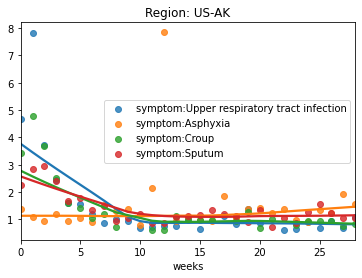

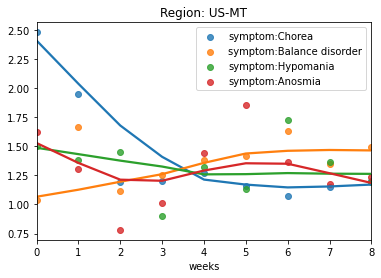

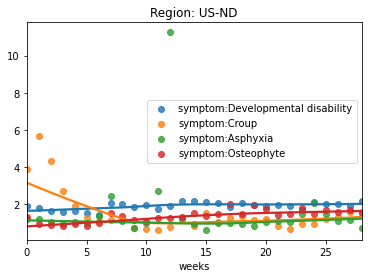

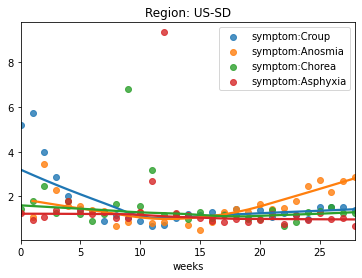

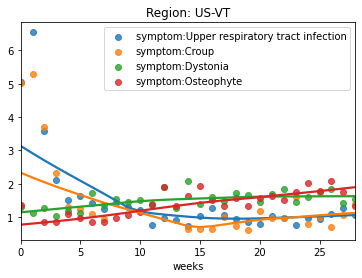

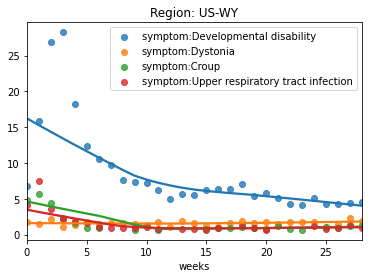

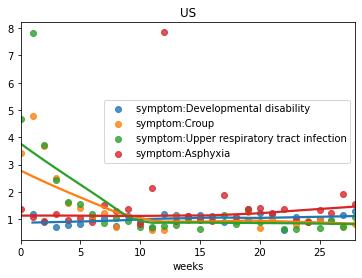

In [742]:
plot_data(only_symptoms_df,complete_df,US_symptoms_df)

In [743]:
filter_col = [col for col in complete_df if col.startswith('symptom:') or col.startswith('date') or col.startswith('open_covid_region_code')]

In [744]:
pcdf = complete_df[filter_col]
pcdf.head()

,open_covid_region_code,date,symptom:Adrenal crisis,symptom:Ageusia,symptom:Amenorrhea,symptom:Anosmia,symptom:Asphyxia,symptom:Atheroma,symptom:Auditory hallucination,symptom:Balance disorder,symptom:Beau's lines,symptom:Bleeding on probing,symptom:Burning mouth syndrome,symptom:Cataplexy,symptom:Chorea,symptom:Cleft lip and cleft palate,symptom:Clouding of consciousness,symptom:Crackles,symptom:Crepitus,symptom:Croup,symptom:Cyanosis,symptom:Depersonalization,symptom:Developmental disability,symptom:Dysautonomia,symptom:Dysgeusia,symptom:Dyspareunia,symptom:Dystonia,symptom:Dysuria,symptom:Epiphora,symptom:Esophagitis,symptom:Eye pain,symptom:Facial swelling,symptom:Fibrocystic breast changes,symptom:Focal seizure,symptom:Gastroparesis,symptom:Gingival recession,symptom:Globus pharyngis,symptom:Goitre,symptom:Grandiosity,symptom:Granuloma,...,symptom:Malabsorption,symptom:Male infertility,symptom:Mitral insufficiency,symptom:Muscle atrophy,symptom:Myoclonus,symptom:Nasal polyp,symptom:Neck mass,symptom:Neutropenia,symptom:Night terror,symptom:Nocturnal enuresis,symptom:Nystagmus,symptom:Onychorrhexis,symptom:Osteophyte,symptom:Papule,symptom:Pericarditis,symptom:Petechia,symptom:Photophobia,symptom:Polyuria,symptom:Ptosis,symptom:Pulmonary edema,symptom:Rectal pain,symptom:Rectal prolapse,symptom:Rheum,symptom:Round ligament pain,symptom:Rumination,symptom:Sensitivity to sound,symptom:Spasticity,symptom:Splenomegaly,symptom:Sputum,symptom:Stomach rumble,symptom:Stridor,symptom:Subdural hematoma,symptom:Tachypnea,symptom:Tenderness,symptom:Thyroid nodule,symptom:Trichoptilosis,symptom:Upper respiratory tract infection,symptom:Urethritis,symptom:Urinary urgency,symptom:Ventricular fibrillation
0,US-AK,2020-03-09,1.054202,NaN,1.272004,0.703133,1.372452,1.389359,NaN,1.590254,1.321730,0.936847,1.104923,1.321730,0.887121,1.405271,NaN,NaN,NaN,3.414222,0.853307,NaN,NaN,0.970661,0.820487,0.920935,1.305818,1.405271,0.752859,1.238190,1.054202,NaN,1.272004,0.987568,1.372452,1.205370,1.054202,1.088016,1.355545,1.205370,...,1.188463,1.088016,0.703133,1.004475,0.703133,0.936847,1.037295,1.791149,0.870214,1.288911,1.238190,1.154649,1.338637,1.238190,NaN,1.823968,0.936847,0.904028,1.104923,0.752859,0.703133,1.221283,1.338637,1.221283,0.853307,1.021382,NaN,1.188463,2.259572,NaN,1.389359,2.392839,1.037295,1.288911,1.104923,1.389359,4.669319,1.021382,NaN,NaN
1,US-AK,2020-03-16,1.162606,NaN,NaN,1.550472,1.100945,1.178518,NaN,0.976629,0.991546,1.069120,0.837394,0.914968,0.945798,0.929886,NaN,0.852312,NaN,4.773744,1.023371,0.759821,1.209349,0.868225,0.883143,1.301840,0.929886,1.209349,0.713078,1.069120,1.007459,0.713078,0.759821,1.038289,1.193436,NaN,1.224267,0.960716,0.899055,1.224267,...,0.697166,0.774739,0.759821,1.193436,NaN,0.914968,NaN,1.038289,NaN,1.007459,0.619592,1.193436,0.697166,0.821482,0.759821,NaN,0.759821,0.743909,NaN,0.899055,0.728991,1.100945,1.115863,1.146693,1.178518,NaN,0.790651,0.883143,2.852312,0.976629,1.286922,0.883143,0.914968,1.115863,1.441074,0.899055,7.827946,1.193436,NaN,NaN
2,US-AK,2020-03-23,1.108901,1.647936,0.947787,4.492292,0.933864,1.137742,0.641472,0.991546,1.108901,0.962705,0.860269,1.137742,1.590254,1.079065,NaN,0.831427,NaN,3.675783,0.875186,NaN,0.904028,0.715067,1.590254,0.772750,1.108901,1.240179,1.487817,0.772750,1.400298,0.831427,1.093983,0.583789,0.627548,0.583789,1.327698,1.006464,1.240179,1.312780,...,1.108901,0.583789,0.671308,0.875186,NaN,0.728991,1.283938,0.860269,0.700149,0.846345,0.685231,1.079065,1.166584,1.312780,1.371457,1.458976,0.947787,0.904028,0.758826,0.816509,0.627548,1.035306,1.093983,1.225261,1.137742,1.108901,0.947787,1.152660,2.945798,0.728991,1.079065,0.991546,1.181502,1.035306,0.758826,0.831427,3.733466,0.875186,NaN,0.700149
3,US-AK,2020-03-30,0.891099,0.891099,0.848334,1.894580,1.187469,0.749876,0.650423,1.089010,1.244157,0.806564,1.018399,1.230234,1.159622,0.989557,0.664346,NaN,NaN,2.503232,1.089010,0.975634,0.734958,NaN,1.371457,0.721034,NaN,0.891099,0.777723,1.089010,1.710592,0.

In [745]:
pca = PCA()
region = pcdf['open_covid_region_code']
date = pcdf['date']
variables = [col for col in pcdf if col.startswith('symptom:')]
df = pcdf.loc[:, variables].values
df = pd.DataFrame(df)

In [746]:
df = np.nan_to_num(df)
pca.fit(df)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

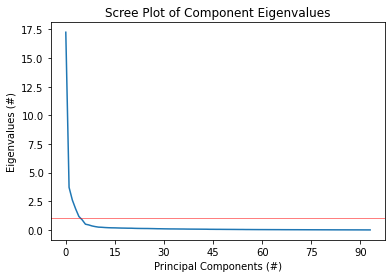

In [747]:
ax = figure().gca()
ax.plot(pca.explained_variance_)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('Principal Components (#)')
plt.ylabel('Eigenvalues (#)')
plt.axhline(y=1, linewidth=1, color='r', alpha=0.5)
plt.title('Scree Plot of Component Eigenvalues')
plt.show()

Text(0.5, 1.0, 'Scree Plot of Variance Explained')

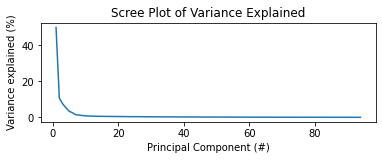

In [748]:
num_pc_components = len(pca.explained_variance_ratio_)
plt.subplot(2,1,1)
plt.plot(np.linspace(1,num_pc_components,num_pc_components),100*pca.explained_variance_ratio_)
plt.xlabel("Principal Component (#)")
plt.ylabel("Variance explained (%)")
plt.title("Scree Plot of Variance Explained")

Text(0.5, 1.0, 'Cumulative Variance Explained to Principal Components')

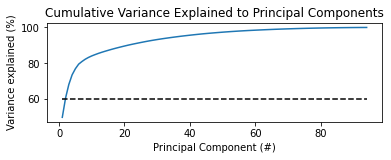

In [749]:
plt.subplot(2,1,2)
plt.plot(np.linspace(1,num_pc_components,num_pc_components),100*np.cumsum(pca.explained_variance_ratio_))
plt.plot(np.linspace(1,num_pc_components,num_pc_components),60*np.ones((num_pc_components,)),'k--')
plt.xlabel("Principal Component (#)")
plt.ylabel("Variance explained (%)")
plt.title("Cumulative Variance Explained to Principal Components")

In [750]:
df = pd.DataFrame(df)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93
0,1.054202,0.000000,1.272004,0.703133,1.372452,1.389359,0.000000,1.590254,1.321730,0.936847,1.104923,1.321730,0.887121,1.405271,0.000000,0.000000,0.0,3.414222,0.853307,0.000000,0.000000,0.970661,0.820487,0.920935,1.305818,1.405271,0.752859,1.238190,1.054202,0.000000,1.272004,0.987568,1.372452,1.205370,1.054202,1.088016,1.355545,1.205370,0.000000,0.803580,...,1.188463,1.088016,0.703133,1.004475,0.703133,0.936847,1.037295,1.791149,0.870214,1.288911,1.238190,1.154649,1.338637,1.238190,0.000000,1.823968,0.936847,0.904028,1.104923,0.752859,0.703133,1.221283,1.338637,1.221283,0.853307,1.021382,0.000000,1.188463,2.259572,0.000000,1.389359,2.392839,1.037295,1.288911,1.104923,1.389359,4.669319,1.021382,0.000000,0.000000
1,1.162606,0.000000,0.000000,1.550472,1.100945,1.178518,0.000000,0.976629,0.991546,1.069120,0.837394,0.914968,0.945798,0.929886,0.000000,0.852312,0.0,4.773744,1.023371,0.759821,1.209349,0.868225,0.883143,1.301840,0.929886,1.209349,0.713078,1.069120,1.007459,0.713078,0.759821,1.038289,1.193436,0.000000,1.224267,0.960716,0.899055,1.224267,0.805569,0.914968,...,0.697166,0.774739,0.759821,1.193436,0.000000,0.914968,0.000000,1.038289,0.000000,1.007459,0.619592,1.193436,0.697166,0.821482,0.759821,0.000000,0.759821,0.743909,0.000000,0.899055,0.728991,1.100945,1.115863,1.146693,1.178518,0.000000,0.790651,0.883143,2.852312,0.976629,1.286922,0.883143,0.914968,1.115863,1.441074,0.899055,7.827946,1.193436,0.000000,0.000000
2,1.108901,1.647936,0.947787,4.492292,0.933864,1.137742,0.641472,0.991546,1.108901,0.962705,0.860269,1.137742,1.590254,1.079065,0.000000,0.831427,0.0,3.675783,0.875186,0.000000,0.904028,0.715067,1.590254,0.772750,1.108901,1.240179,1.487817,0.772750,1.400298,0.831427,1.093983,0.583789,0.627548,0.583789,1.327698,1.006464,1.240179,1.312780,1.546494,0.758826,...,1.108901,0.583789,0.671308,0.875186,0.000000,0.728991,1.283938,0.860269,0.700149,0.846345,0.685231,1.079065,1.166584,1.312780,1.371457,1.458976,0.947787,0.904028,0.758826,0.816509,0.627548,1.035306,1.093983,1.225261,1.137742,1.108901,0.947787,1.152660,2.945798,0.728991,1.079065,0.991546,1.181502,1.035306,0.758826,0.831427,3.733466,0.875186,0.000000,0.700149
3,0.891099,0.891099,0.848334,1.894580,1.187469,0.749876,0.650423,1.089010,1.244157,0.806564,1.018399,1.230234,1.159622,0.989557,0.664346,0.000000,0.0,2.503232,1.089010,0.975634,0.734958,0.000000,1.371457,0.721034,0.000000,0.891099,0.777723,1.089010,1.710592,0.693187,0.834411,0.607658,0.579811,0.877176,1.230234,0.734958,1.018399,0.877176,0.777723,0.791646,...,1.272999,1.131775,0.664346,0.905022,0.565888,0.862258,0.607658,0.791646,0.734958,1.300845,0.877176,1.018399,0.000000,1.187469,1.004475,1.498757,0.848334,0.000000,0.679264,1.032322,0.000000,0.975634,0.000000,1.258081,0.905022,0.734958,0.000000,0.777723,2.418697,0.636499,1.244157,0.693187,1.286922,0.989557,0.932869,1.470910,2.432621,0.975634,0.791646,0.707111
4,1.002486,0.730980,1.074092,0.673297,0.959722,1.145699,0.000000,1.074092,0.959722,1.303829,0.916957,0.000000,1.576330,1.002486,0.000000,0.716062,0.0,1.590254,1.246146,0.702138,0.802586,0.000000,1.131775,0.802586,0.902039,1.274988,0.000000,1.447041,1.274988,0.587767,0.673297,0.831427,1.189458,0.630532,1.203381,1.131775,1.203381,0.959722,0.874192,0.644455,...,0.973645,0.744903,0.000000,0.787668,0.000000,0.945798,0.716062,0.702138,0.874192,0.916957,0.945798,0.572849,0.730980,0.644455,0.888115,0.959722,0.945798,0.572849,0.988563,0.930880,1.031328,1.046246,0.816509,1.145699,0.902039,0.744903,0.716062,1.002486,1.690701,1.017404,0.000000,0.845351,0.959722,0.916957,0.859274,1.375435,1.619095,1.002486,0.000000,0.000000


In [751]:
pca2 = PCA(n_components=2)
df = PCAtransformation(df)
df = pd.concat([date, df], axis=1)
df = pd.concat([region,df], axis=1)

     principal component 1  principal component 2
0                -1.562510               4.469774
1                 0.301599               7.770326
2                -0.597778               5.186733
3                -1.180907               2.751603
4                -1.209683               1.223819
..                     ...                    ...
149               2.686325              -1.680814
150               1.938392              -1.162733
151               2.019940              -0.518103
152               2.020994              -0.545528
153               2.221573              -0.225289

[154 rows x 2 columns]


In [752]:
explained_variance = pca2.explained_variance_ratio_
explained_variance

array([0.49948696, 0.10755234])

In [753]:
targets = df.open_covid_region_code.unique()
print(targets)
generate_rand = lambda n: list(map(lambda i: "#" + "%06x" % random.randint(0, 0xFFFFFF),range(n)))
colors = generate_rand(60)

['US-AK' 'US-MT' 'US-ND' 'US-SD' 'US-VT' 'US-WY']


In [754]:
df.head()

,open_covid_region_code,date,principal component 1,principal component 2
0,US-AK,2020-03-09,-1.562510,4.469774
1,US-AK,2020-03-16,0.301599,7.770326
2,US-AK,2020-03-23,-0.597778,5.186733
3,US-AK,2020-03-30,-1.180907,2.751603
4,US-AK,2020-04-06,-1.209683,1.223819


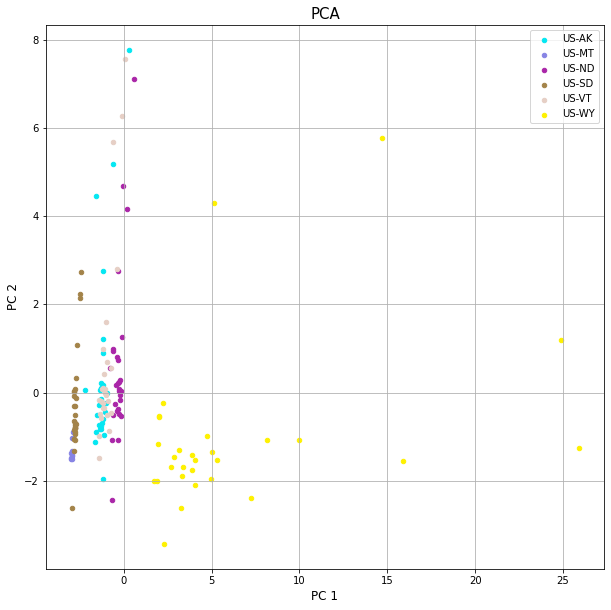

In [755]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC 1', fontsize = 12)
ax.set_ylabel('PC 2', fontsize = 12)
ax.set_title('PCA', fontsize = 15)
for target, color in zip(targets,colors):
    indices = df['open_covid_region_code'] == target
    ax.scatter(df.loc[indices, 'principal component 1']
               , df.loc[indices, 'principal component 2']
               , c = color
               , s = 20)
ax.legend(targets)
ax.grid()

In [756]:
print ( "Components = ", pca2.n_components_ , "\nTotal explained variance = ",
      round(pca2.explained_variance_ratio_.sum(),5)  )

Components =  2 
Total explained variance =  0.60704


best number of clusters is:  8


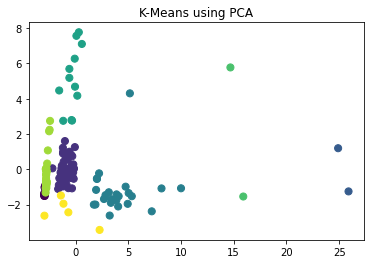

best number of clusters is:  8


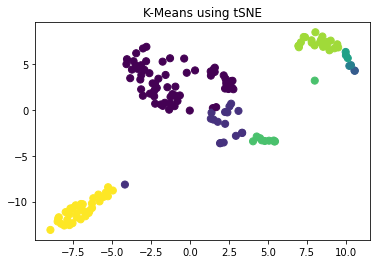

['#90b0e8', '#b70c4a', '#efc5b8', '#cf28a5', '#c23a3f', '#f13257', '#bbc920', '#0d66ef', '#bb6415', '#c09c51', '#aa1dea', '#809b5e', '#9b6bf4', '#95f329', '#47726f', '#6087e5', '#b890a9', '#71611b', '#cd1f55', '#00bf25', '#59b6e1', '#816b9c', '#75e742', '#917385', '#ade1de', '#d4cc43', '#893446', '#3b36c0', '#4c2648', '#f806fd', '#f6f18e', '#6ee97b', '#6477d0', '#4ac529', '#79e304', '#33ed69', '#436d34', '#b3ce9a', '#9e2f24', '#07d6af', '#e67897', '#11838d', '#578111', '#8d774d', '#51d3b7', '#de1c81', '#796e7e', '#4179f6', '#2d8f9d', '#d60626', '#9ca8ae', '#a84d05', '#14961a', '#0b0ece', '#d00776', '#d9de88', '#279180', '#4e421e', '#dd394d', '#8bc69f']


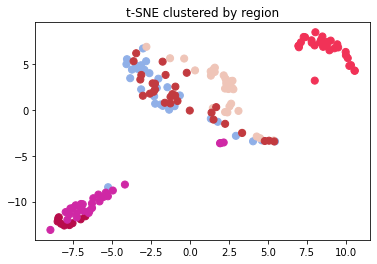

In [714]:
classify_KMeans(complete_df)

Minimum error:  8.331660692951015 with std:  3.932326716362536  at K = 6


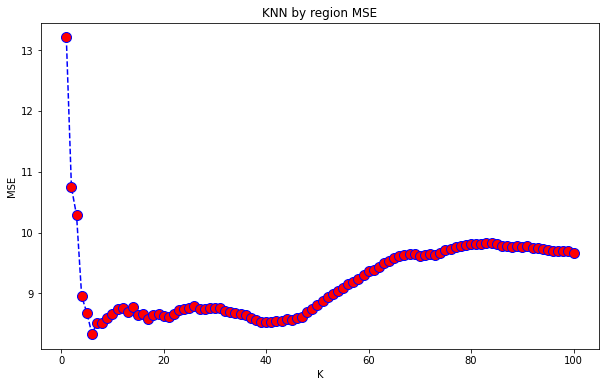

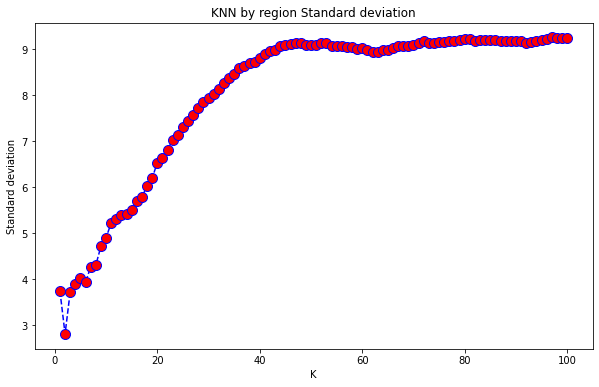

Accord to k = sqrt(n)  13  error is:  8.696221925303812


In [715]:
knn_classifier_correct(complete_df, 'region')

Minimum error:  7.716809144086861 at depth = 15


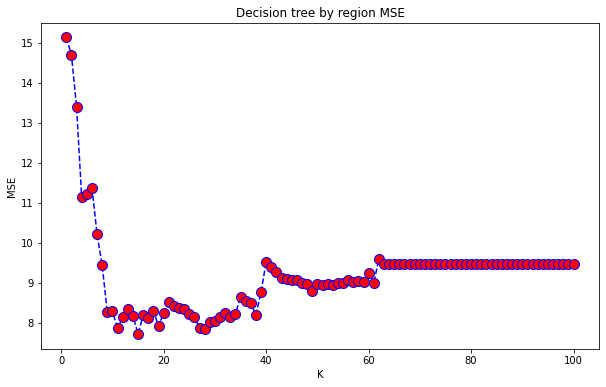

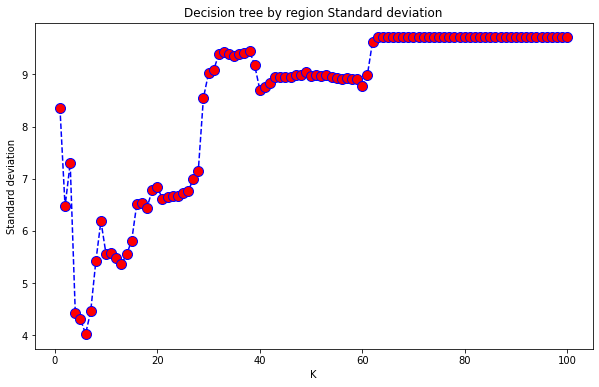

Best Score from sqrt:  19.424731182795696
Accuracy:  [0.74193548 0.16129032 0.19354839 0.58064516 0.1       ]


In [716]:
decisionTree_classifier_correct(complete_df, 'region')

Minimum error:  4.08055320945946 at K = 16
Accord to k = sqrt(n)  13  error is:  4.1114664960818805


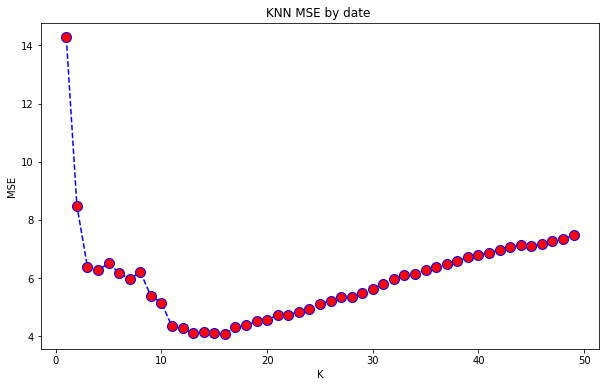

In [717]:
knn_classifier_correct(complete_df, 'time')

Minimum error:  5.034504556639973 at K = 18
Best Score:  7.378378378378378
Accuracy:  0.35135135135135137


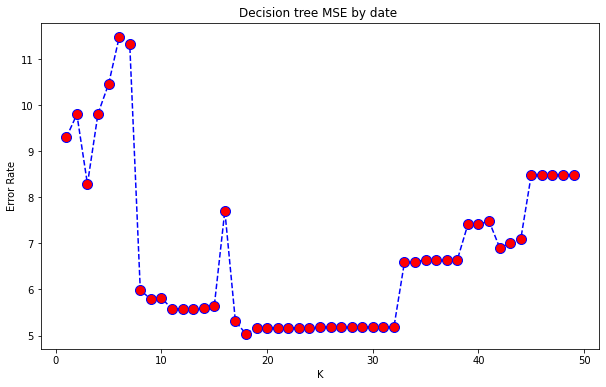

In [718]:
decisionTree_classifier_correct(complete_df, "time")

Test with different cross validation

[array(['US-AK', 'US-MT'], dtype=object), array(['US-ND'], dtype=object), array(['US-SD'], dtype=object), array(['US-VT'], dtype=object), array(['US-WY'], dtype=object)]
['US-AK' 'US-MT']
Minimum error:  3.0004177109440273 at K = 42
['US-ND']
Minimum error:  4.958490347875902 at K = 81
['US-SD']
Minimum error:  22.6360153256705 at K = 3
['US-VT']
Minimum error:  3.250336313324819 at K = 45
['US-WY']
Minimum error:  2.097919447872849 at K = 74


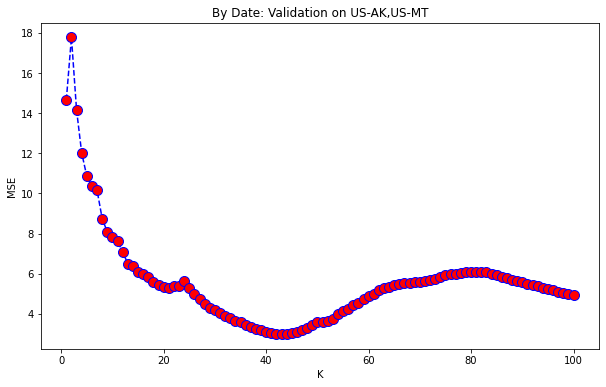

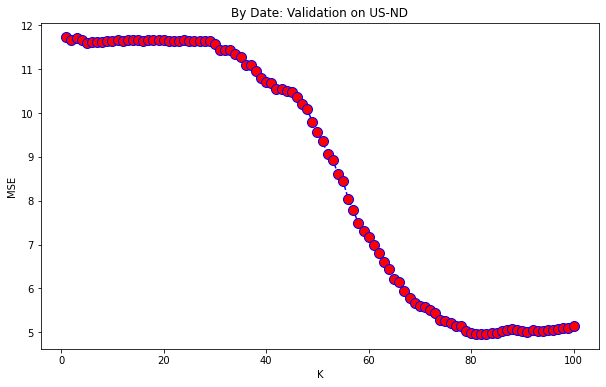

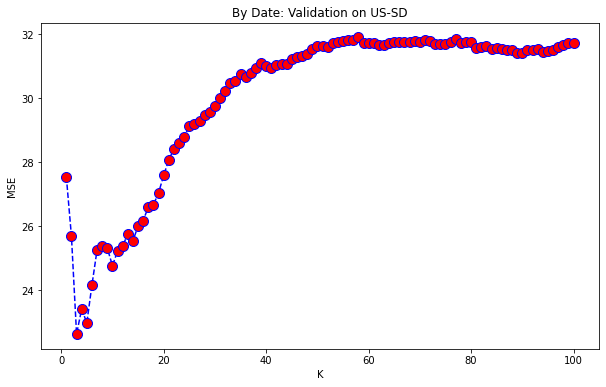

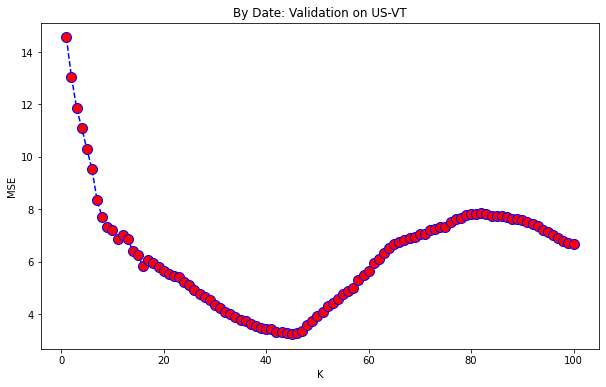

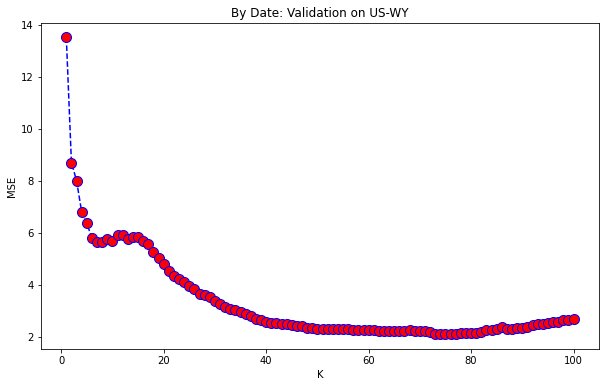

In [719]:
knn_classifier_test(complete_df, 'region')

[array(['US-AK', 'US-MT'], dtype=object), array(['US-ND'], dtype=object), array(['US-SD'], dtype=object), array(['US-VT'], dtype=object), array(['US-WY'], dtype=object)]
['US-AK' 'US-MT']
Minimum error:  3.9981346509351887 at depth level = 30
['US-ND']
Minimum error:  5.670344827586207 at depth level = 63
['US-SD']
Minimum error:  32.55726124137932 at depth level = 63
['US-VT']
Minimum error:  0.18699780861943024 at depth level = 35
['US-WY']
Minimum error:  2.275998694217228 at depth level = 53


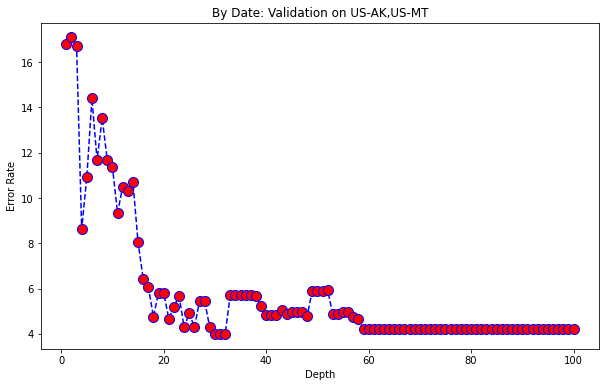

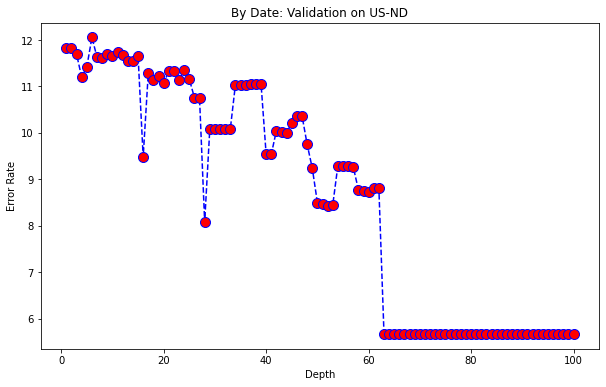

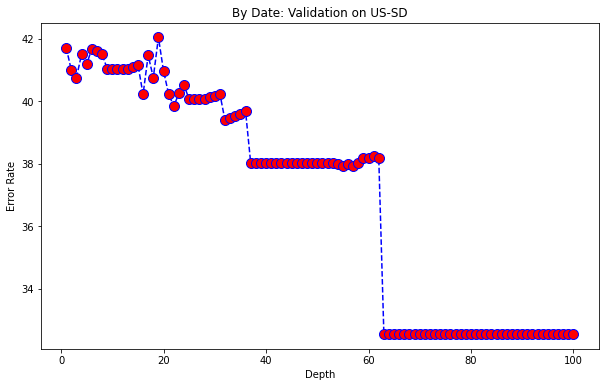

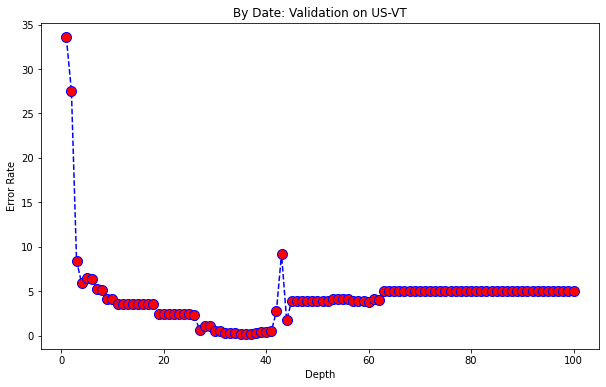

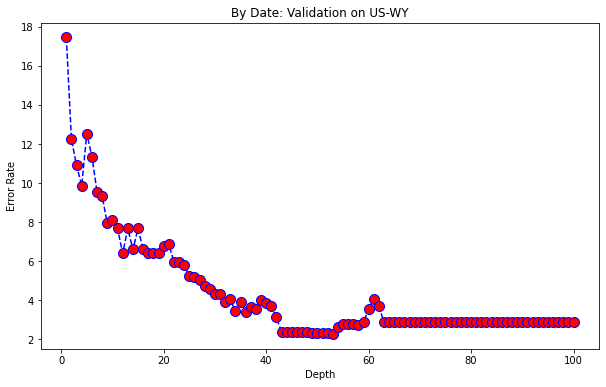

In [720]:
decisionTree_regressor_test(complete_df, 'region')

[array(['2020-03-09T00:00:00.000000000', '2020-03-16T00:00:00.000000000',
       '2020-03-23T00:00:00.000000000', '2020-03-30T00:00:00.000000000',
       '2020-04-06T00:00:00.000000000', '2020-04-13T00:00:00.000000000'],
      dtype='datetime64[ns]'), array(['2020-04-20T00:00:00.000000000', '2020-04-27T00:00:00.000000000',
       '2020-05-04T00:00:00.000000000', '2020-05-11T00:00:00.000000000',
       '2020-05-18T00:00:00.000000000', '2020-05-25T00:00:00.000000000'],
      dtype='datetime64[ns]'), array(['2020-06-01T00:00:00.000000000', '2020-06-08T00:00:00.000000000',
       '2020-06-15T00:00:00.000000000', '2020-06-22T00:00:00.000000000',
       '2020-06-29T00:00:00.000000000', '2020-07-06T00:00:00.000000000'],
      dtype='datetime64[ns]'), array(['2020-07-13T00:00:00.000000000', '2020-07-20T00:00:00.000000000',
       '2020-07-27T00:00:00.000000000', '2020-08-03T00:00:00.000000000',
       '2020-08-10T00:00:00.000000000', '2020-08-17T00:00:00.000000000'],
      dtype='datetime64[ns

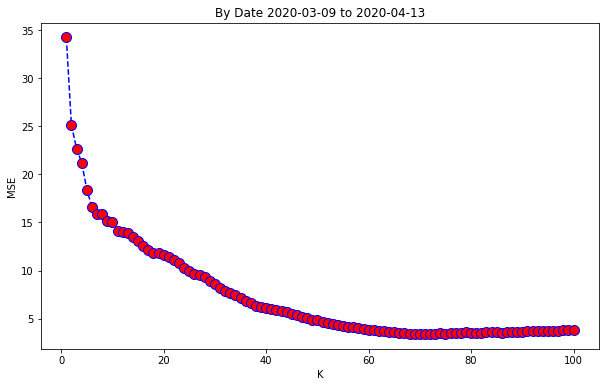

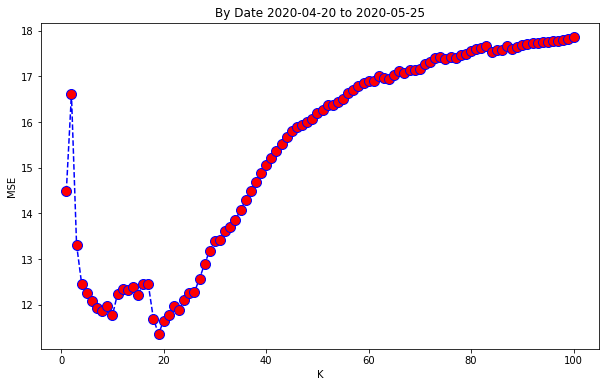

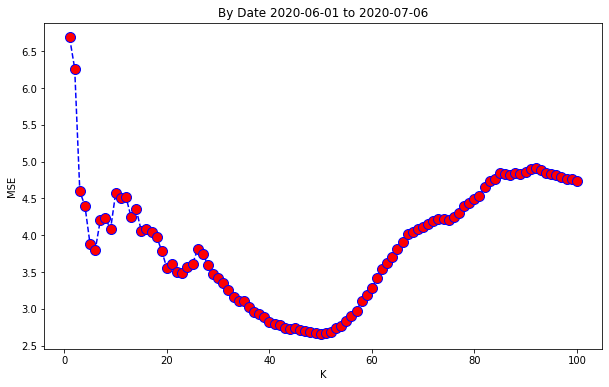

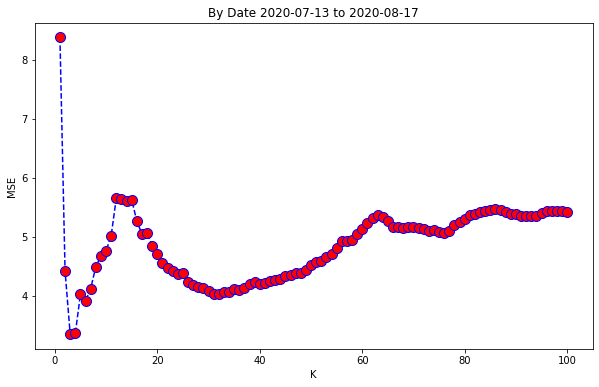

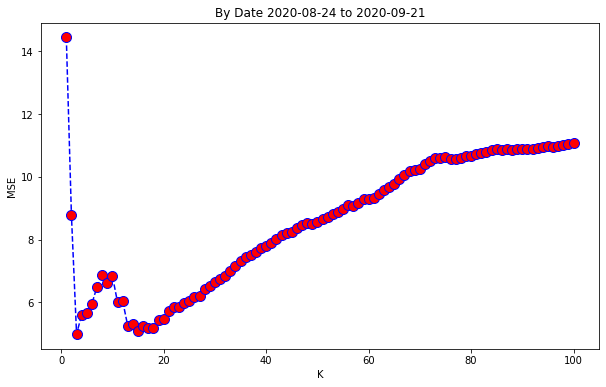

In [721]:
knn_classifier_test(complete_df, 'time')

[array(['2020-03-09T00:00:00.000000000', '2020-03-16T00:00:00.000000000',
       '2020-03-23T00:00:00.000000000', '2020-03-30T00:00:00.000000000',
       '2020-04-06T00:00:00.000000000', '2020-04-13T00:00:00.000000000'],
      dtype='datetime64[ns]'), array(['2020-04-20T00:00:00.000000000', '2020-04-27T00:00:00.000000000',
       '2020-05-04T00:00:00.000000000', '2020-05-11T00:00:00.000000000',
       '2020-05-18T00:00:00.000000000', '2020-05-25T00:00:00.000000000'],
      dtype='datetime64[ns]'), array(['2020-06-01T00:00:00.000000000', '2020-06-08T00:00:00.000000000',
       '2020-06-15T00:00:00.000000000', '2020-06-22T00:00:00.000000000',
       '2020-06-29T00:00:00.000000000', '2020-07-06T00:00:00.000000000'],
      dtype='datetime64[ns]'), array(['2020-07-13T00:00:00.000000000', '2020-07-20T00:00:00.000000000',
       '2020-07-27T00:00:00.000000000', '2020-08-03T00:00:00.000000000',
       '2020-08-10T00:00:00.000000000', '2020-08-17T00:00:00.000000000'],
      dtype='datetime64[ns

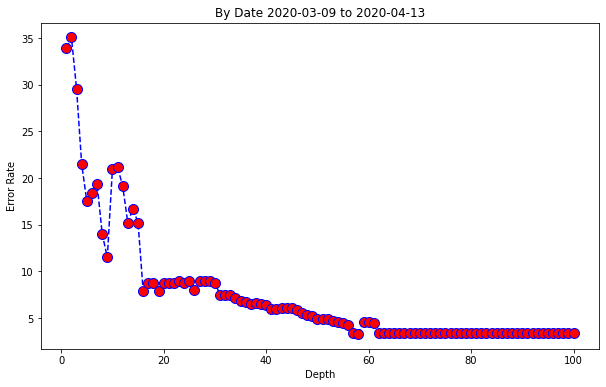

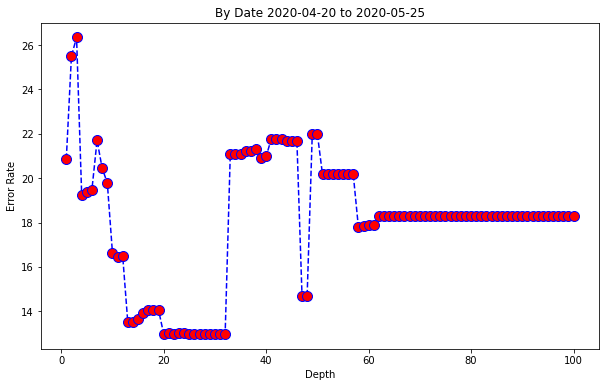

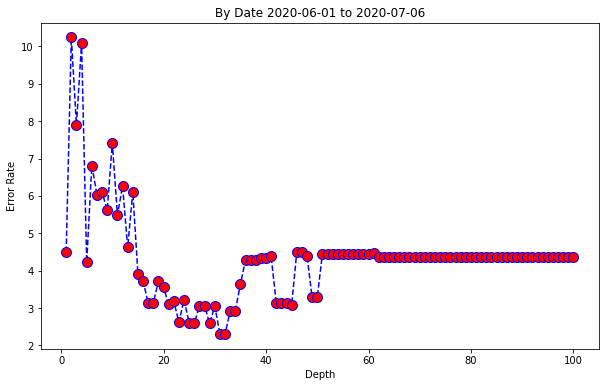

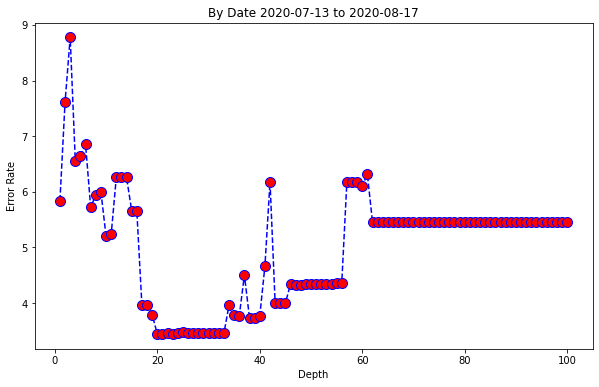

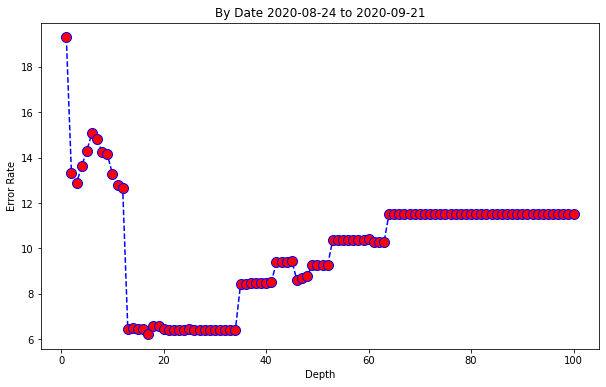

In [722]:
decisionTree_regressor_test(complete_df, 'time')